# VQE using QNG

This is a short tutorial on how to implement VQE using quantum natural gradient descent.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

import pennylane as qml
from pennylane import expval

To run and optimize quantum circuits using Pennylane, we first need to specify a device (simulator or hardware).

In [2]:
dev = qml.device("default.qubit", wires=2)

The Hamiltonian-of-interest is: 

$$
\hat{H} = \alpha (I \otimes Z + Z \otimes I) + \beta (X \otimes X) 
$$

where $\alpha = 0.4$ and $\beta = 0.2$.

In [3]:
alpha = 0.4
beta = 0.2

coeffs = [alpha, alpha, beta]
obs_list = [
    qml.PauliZ(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliX(0) @ qml.PauliX(1)
]

Our ansatz is a simple two-qubit circuit composed of Y rotations and a CNOT gate. There are 4 parameters in total.

In [4]:
def circuit(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    
    qml.CNOT(wires=wires)
    
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])

We are going to create a collection of QNodes (quantum circuits) that can be executed to compute the expectation value of the energy.

In [5]:
qnodes = qml.map(circuit, obs_list, dev, measure='expval')
energy_expval = qml.dot([alpha, alpha, beta], qnodes)

Now to set up the optimizer, we will test both vanilla and natural gradient descent methods. First, we set the stepsize, number of iterations, and initial parameters.

In [6]:
step_size = 0.3
max_iterations = 200

initial_params = np.random.uniform(low=0, high=2*np.pi, size=4).tolist()

conv_tol = 1e-06

print_freq = 10

We start with the vanilla gradient descent:

In [7]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = initial_params
prev_energy = energy_expval(params)
gd_energies = [prev_energy]

for n in range(max_iterations):
    
    # Take step
    params = opt.step(energy_expval, params)
    
    # Compute energy
    energy = energy_expval(params)
    gd_energies.append(energy)
    
    # Compute difference wrt previous energy (to test termination criterion)
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        gd_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', gd_nsteps)

Iteration = 0,  Energy = -0.63032068 Ha,  Convergence parameter = 0.07343203 Ha
Iteration = 10,  Energy = -0.77038953 Ha,  Convergence parameter = 0.00320293 Ha
Iteration = 20,  Energy = -0.79367774 Ha,  Convergence parameter = 0.00190524 Ha
Iteration = 30,  Energy = -0.80910017 Ha,  Convergence parameter = 0.00125522 Ha
Iteration = 40,  Energy = -0.81829880 Ha,  Convergence parameter = 0.00066200 Ha
Iteration = 50,  Energy = -0.82251771 Ha,  Convergence parameter = 0.00026277 Ha
Iteration = 60,  Energy = -0.82401677 Ha,  Convergence parameter = 0.00008358 Ha
Iteration = 70,  Energy = -0.82446215 Ha,  Convergence parameter = 0.00002320 Ha
Iteration = 80,  Energy = -0.82458126 Ha,  Convergence parameter = 0.00000598 Ha
Iteration = 90,  Energy = -0.82461137 Ha,  Convergence parameter = 0.00000148 Ha

Final convergence parameter = 0.00000097 Ha
Final value of the ground-state energy = -0.82461475 Ha

Final circuit parameters = 
 [-0.36020257446336107, 0.8244103517370496, 3.408214529981979

Now we look at natural gradient descent. We first look at the block-diagonal approximation then diagonal approximation.

In [8]:
qnodes[0].metric_tensor([initial_params], diag_approx=False)

array([[ 0.25      ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.25      ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.25      , -0.13540187],
       [ 0.        ,  0.        , -0.13540187,  0.25      ]])

In [9]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_block_diag = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params])),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_block_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_block_diag_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_block_diag_nsteps)

Iteration = 0,  Energy = -0.74060322 Ha,  Convergence parameter = 0.18371457 Ha
Iteration = 10,  Energy = -0.81565822 Ha,  Convergence parameter = 0.00318043 Ha
Iteration = 20,  Energy = -0.82450621 Ha,  Convergence parameter = 0.00007459 Ha

Final convergence parameter = 0.00000075 Ha
Final value of the ground-state energy = -0.82462003 Ha

Final circuit parameters = 
 [-0.39823469  0.89965486  3.45883873  2.20250376]
Number of iterations =  29


Lastly, we look at the diagonal approximation.

In [10]:
qnodes[0].metric_tensor([initial_params], diag_approx=True)

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [11]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_diag = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(qnodes[0].metric_tensor([params], diag_approx=True)),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_diag.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_diag_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_diag_nsteps)

Iteration = 0,  Energy = -0.74899316 Ha,  Convergence parameter = 0.19210451 Ha
Iteration = 10,  Energy = -0.81985708 Ha,  Convergence parameter = 0.00239982 Ha
Iteration = 20,  Energy = -0.82460153 Ha,  Convergence parameter = 0.00001638 Ha

Final convergence parameter = 0.00000077 Ha
Final value of the ground-state energy = -0.82462023 Ha

Final circuit parameters = 
 [-0.37439158  0.85019728  3.42758104  2.25615663]
Number of iterations =  25


In [12]:
def compute_metric_tensor(p):
    metric = np.array([[0.25, 0, 0.25*np.sin(p[1]), 0],
                       [0, 0.25, 0, 0.25*np.cos(params[0])],
                       [0.25*np.sin(p[1]), 0, 0.25, -0.25*np.cos(p[1])*np.sin(p[0])],
                       [0, 0.25*np.cos(p[0]), -0.25*np.cos(p[1])*np.sin(p[0]), 0.25]])
    return metric

In [13]:
compute_metric_tensor(initial_params)

array([[ 0.25      ,  0.        ,  0.16355695,  0.        ],
       [ 0.        ,  0.25      ,  0.        ,  0.23268257],
       [ 0.16355695,  0.        ,  0.25      , -0.13540187],
       [ 0.        ,  0.17449169, -0.13540187,  0.25      ]])

In [14]:
params = initial_params
prev_energy = energy_expval(params)
qngd_energies_exact = [prev_energy]

for n in range(max_iterations):
    
    grad_cost = qml.grad(energy_expval, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(np.linalg.pinv(compute_metric_tensor(params)),
                                         grad_at_point)

    energy = energy_expval(params)
    qngd_energies_exact.append(energy)
    
    conv = np.abs(energy - prev_energy)

    if n % print_freq == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {'
              ':.8f} Ha'.format(n, energy, conv))

    if conv <= conv_tol:
        qngd_exact_nsteps = n
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print('Final circuit parameters = \n', params)
print('Number of iterations = ', qngd_exact_nsteps)

Iteration = 0,  Energy = -0.78496173 Ha,  Convergence parameter = 0.22807308 Ha
Iteration = 10,  Energy = -0.82461897 Ha,  Convergence parameter = 0.00000336 Ha

Final convergence parameter = 0.00000051 Ha
Final value of the ground-state energy = -0.82462080 Ha

Final circuit parameters = 
 [-0.57097593  1.10541653  3.66152038  1.97173747]
Number of iterations =  12


Try plotting the results.

In [15]:
exact_energy = -np.sqrt(4*alpha**2 + beta**2)

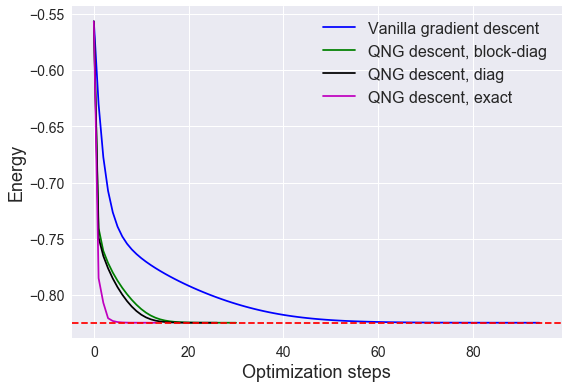

In [16]:
plt.style.use("seaborn")
fig = plt.figure()
plt.plot(gd_energies, "b", label="Vanilla gradient descent")
plt.plot(qngd_energies_block_diag, "g", label="QNG descent, block-diag")
plt.plot(qngd_energies_diag, "k", label="QNG descent, diag")
plt.plot(qngd_energies_exact, "m", label="QNG descent, exact")

plt.axhline(y=exact_energy, color='r', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Energy", fontsize=18)
plt.xlabel("Optimization steps", fontsize=18)
plt.legend(fontsize=16)

plt.tight_layout()

In [17]:
print('N steps')
print('=======\n')

print('Vanilla GD.      : {0:d}'.format(gd_nsteps))
print('QNGD, block-diag : {0:d}'.format(qngd_block_diag_nsteps))
print('QNGD, diag       : {0:d}'.format(qngd_diag_nsteps))
print('QNGD, exact      : {0:d}'.format(qngd_exact_nsteps))

N steps

Vanilla GD.      : 93
QNGD, block-diag : 29
QNGD, diag       : 25
QNGD, exact      : 12


Convergence looks good! How about energy error?

In [18]:
print('Energy error')
print('============\n')

print('Vanilla GD.      : {0:.10f}'.format(np.min(gd_energies) - exact_energy))
print('QNGD, block-diag : {0:.10f}'.format(np.min(qngd_energies_block_diag) - exact_energy))
print('QNGD, diag       : {0:.10f}'.format(np.min(qngd_energies_diag) - exact_energy))
print('QNGD, exact      : {0:.10f}'.format(np.min(qngd_energies_exact) - exact_energy))

Energy error

Vanilla GD.      : 0.0000063744
QNGD, block-diag : 0.0000010927
QNGD, diag       : 0.0000008981
QNGD, exact      : 0.0000003297
